#### Section 1: Importing Necessary Libraries

In [1]:
### Basic Imports
import numpy as np
import pandas as pd
import random
import toml
import os
import logging
import math
import json
from datetime import datetime
import seaborn as sns
### Matplot Lib Imports
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

### Parallel Processing Libraries
from functools import partial
import time
from concurrent.futures import ProcessPoolExecutor, as_completed,ThreadPoolExecutor
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import concurrent.futures

### Scipy Imports
from scipy.spatial import distance
from shapely.geometry import Point, MultiPoint
from shapely.ops import cascaded_union
from scipy.spatial import distance
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import cdist
### Other Imports
import warnings
from copy import deepcopy
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Any
from abc import ABC, abstractmethod
from matplotlib.colors import LinearSegmentedColormap


#### Section 1.1: Basic Utility Functions

In [2]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((np.array(point1) - np.array(point2)) ** 2))

def create_distance_matrix(locations):
    n = len(locations)
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            matrix[i][j] = euclidean_distance(locations[i], locations[j])
    return matrix

def create_charging_distance_matrix(locations, charging_stations):
    matrix = np.zeros((len(locations), len(charging_stations)))
    for i, loc in enumerate(locations):
        for j, station in enumerate(charging_stations):
            matrix[i][j] = euclidean_distance(loc, station)
    return matrix

In [3]:
class EVRPSolution:
    def __init__(self):
        self.routes = []
        self.vehicle_types = []
        self.route_loads = []
        self.route_distances = []
        self.route_energies = []
        self.delivery_times = []
        self.computation_time = 0.0

    def add_route(self, route, vehicle_type, load):
        self.routes.append(route)
        self.vehicle_types.append(vehicle_type)
        self.route_loads.append(load)

In [4]:
class EVConfig:
    def __init__(self):
        self.categories = {
            'small': {
                'battery_capacity': 35,
                'base_weight': 1500,
                'load_capacity': 500
            },
            'medium': {
                'battery_capacity': 40,
                'base_weight': 1800,
                'load_capacity': 600
            },
            'large': {
                'battery_capacity': 45,
                'base_weight': 2000,
                'load_capacity': 700
            },
            'xlarge': {
                'battery_capacity': 50,
                'base_weight': 2200,
                'load_capacity': 800
            }
        }
        self.initial_charging = 100
        self.speed = 25
        self.energy_consumption_rate = 0.15
        self.weight_factor = 0.05
        self.battery_safety_margin = 40

In [5]:
class EVRPInstance:
    def __init__(self, instance_id, depot_location, customer_locations, 
                 charging_stations, customer_items_weights, charging_rate):
        self.instance_id = instance_id
        self.depot_location = depot_location
        self.customer_locations = customer_locations
        self.charging_stations = charging_stations
        self.customer_items_weights = customer_items_weights
        self.charging_rate = charging_rate
        
        # Create distance matrices
        self.distance_matrix = self._create_distance_matrix()
        self.charging_distance_matrix = self._create_charging_distance_matrix()

    def _create_distance_matrix(self):
        locations = [self.depot_location] + self.customer_locations
        return create_distance_matrix(locations)

    def _create_charging_distance_matrix(self):
        locations = [self.depot_location] + self.customer_locations
        return create_charging_distance_matrix(locations, self.charging_stations)

In [6]:
class GreedyEVRPSolver:
    def __init__(self, instance: EVRPInstance):
        self.instance = instance
        self.ev_config = EVConfig()
        self.best_solution = EVRPSolution()
        self.served_customers = set()
        
        # NEW: Fleet management attributes
        self.fleet = {
            'xlarge': 0,  # 800kg capacity
            'large': 0,   # 700kg capacity
            'medium': 0,  # 600kg capacity
            'small': 0    # 500kg capacity
        }
        self.available_vehicles = []

    def calculate_min_vehicles_needed(self) -> int:
        """Calculate minimum number of vehicles needed based on total demand"""
        total_demand = sum(self.instance.customer_items_weights)
        unit_fleet_capacity = (
            self.ev_config.categories['xlarge']['load_capacity'] +
            self.ev_config.categories['large']['load_capacity'] +
            self.ev_config.categories['medium']['load_capacity'] +
            self.ev_config.categories['small']['load_capacity']
        )
        min_vehicles = math.ceil(total_demand / (unit_fleet_capacity))
        print(min_vehicles)
        return max(1, min_vehicles)

    def initialize_fleet(self, min_vehicles: int) -> None:
        """Initialize fleet with minimum required vehicles"""
        self.fleet = {
            'xlarge': min_vehicles,
            'large': min_vehicles,
            'medium': min_vehicles,
            'small': min_vehicles
        }
        self.generate_vehicle_sequence()

    def generate_vehicle_sequence(self) -> None:
        self.available_vehicles = []
        for v_type in ['xlarge','large', 'medium', 'small']:
            self.available_vehicles.extend([v_type] * self.fleet[v_type])

    def increase_fleet_size(self) -> None:
        for v_type in self.fleet:
            self.fleet[v_type] += 1
        self.generate_vehicle_sequence()

    def solve(self) -> EVRPSolution:
        self.served_customers.clear()
        solution = EVRPSolution()
        
        # Calculate initial fleet size
        min_vehicles = self.calculate_min_vehicles_needed()
        self.initialize_fleet(min_vehicles)
        
        # Initialize unserved customers
        unserved = list(range(len(self.instance.customer_locations)))
        current_vehicle_index = 0
        
        while unserved:
            # Check if we need more vehicles
            if current_vehicle_index >= len(self.available_vehicles):
                self.increase_fleet_size()
                current_vehicle_index = 0
            
            # Get next vehicle type
            vehicle_type = self.available_vehicles[current_vehicle_index]
            
            # Create route with specified vehicle type
            route, load = self.create_route(unserved, vehicle_type)
            
            if not route or len(route) <= 2:  # No feasible route found
                current_vehicle_index += 1
                continue
            
            # Insert charging stations
            route_with_charging = self.insert_charging_stations(route, load, vehicle_type)
            
            # Calculate route metrics
            distance, energy, time, battery_levels = self.calculate_route_metrics(
                route_with_charging, load, vehicle_type)
            
            # Update solution
            solution.add_route(route_with_charging, vehicle_type, load)
            solution.route_distances.append(distance)
            solution.route_energies.append(energy)
            solution.delivery_times.append(time)
            
            # Update unserved customers
            unserved = [c for c in unserved if c not in self.served_customers]
            current_vehicle_index += 1
        
        return solution

    def create_route(self, unserved_customers: List[int], vehicle_type: str) -> Tuple[List[int], float]:
        if not unserved_customers:
            return [], 0
            
        route = [0]  # Start from depot
        current_load = 0
        current_battery = self.ev_config.initial_charging
        vehicle_specs = self.ev_config.categories[vehicle_type]
        
        while unserved_customers:
            next_customer = self.find_best_next_customer(
                route[-1],
                unserved_customers,
                current_load,
                current_battery,
                vehicle_type
            )
            
            if next_customer is None:
                break
                
            # Add customer to route
            customer_id = next_customer + 1  # Convert to 1-based indexing
            route.append(customer_id)
            
            # Update tracking variables
            current_load += self.instance.customer_items_weights[next_customer]
            distance = self.calculate_distance(route[-2], customer_id)
            energy_used = self.calculate_energy_consumption(
                distance, current_load, vehicle_type)
            current_battery -= energy_used
            
            # Mark customer as served
            self.served_customers.add(next_customer)
            
        route.append(0)  # Return to depot
        return route, current_load

    def find_best_next_customer(self, current_pos: int, unserved_customers: List[int],
                              current_load: float, current_battery: float,
                              vehicle_type: str) -> int:
        best_customer = None
        min_distance = float('inf')
        vehicle_specs = self.ev_config.categories[vehicle_type]
        
        # Special handling when at depot
        if current_pos == 0:
            # Simply find the nearest feasible customer when starting from depot
            for customer_idx in unserved_customers:
                if customer_idx in self.served_customers:
                    continue
                    
                customer_id = customer_idx + 1
                distance_to_customer = self.calculate_distance(current_pos, customer_id)
                customer_demand = self.instance.customer_items_weights[customer_idx]
                
                # Check load feasibility for specific vehicle type
                if current_load + customer_demand > vehicle_specs['load_capacity']:
                    continue
                
                if distance_to_customer < min_distance:
                    min_distance = distance_to_customer
                    best_customer = customer_idx
        else:
            # When not at depot, use distance comparison
            distance_to_depot = self.calculate_distance(current_pos, 0)
            
            for customer_idx in unserved_customers:
                if customer_idx in self.served_customers:
                    continue
                    
                customer_id = customer_idx + 1
                distance_to_customer = self.calculate_distance(current_pos, customer_id)
                customer_demand = self.instance.customer_items_weights[customer_idx]
                
                
                # Check load feasibility for specific vehicle type
                if current_load + customer_demand > vehicle_specs['load_capacity']:
                    continue
                
                if distance_to_customer < min_distance:
                    min_distance = distance_to_customer
                    best_customer = customer_idx
                    
        return best_customer

    def insert_charging_stations(self, route: List[int], load: float, 
                               vehicle_type: str) -> List[int]:
        """Inserts charging stations when needed based on energy consumption"""
        if len(route) <= 2:  # Only depot-customer-depot
            return route
            
        new_route = [0]  # Start at depot
        current_battery = self.ev_config.initial_charging
        current_load = load
        
        for i in range(1, len(route)):
            from_loc = route[i-1]
            to_loc = route[i]
            
            # Calculate energy needed for next leg
            distance = self.calculate_distance(from_loc, to_loc)
            energy_needed = self.calculate_energy_consumption(
                distance, current_load, vehicle_type)
            
            # Check if charging is needed
            if current_battery - energy_needed < self.ev_config.battery_safety_margin:
                # Find nearest charging station
                charging_station = self.find_nearest_charging_station(new_route[-1])
                new_route.append(charging_station)
                current_battery = self.ev_config.initial_charging
                
                # Recalculate energy needed from charging station
                distance = self.calculate_distance(charging_station, to_loc)
                energy_needed = self.calculate_energy_consumption(
                    distance, current_load, vehicle_type)
            
            new_route.append(to_loc)
            current_battery -= energy_needed
            
            # Update load after delivery (if it's a customer)
            if to_loc > 0:
                current_load -= self.instance.customer_items_weights[to_loc-1]
        
        return new_route

    def calculate_route_metrics(self, route: List[int], load: float,
                              vehicle_type: str) -> Tuple[float, float, float, List[Tuple[int, float]]]:
        """Calculate distance, energy consumption, delivery time and battery levels"""
        total_distance = 0
        total_energy = 0
        total_time = 0
        current_load = load
        current_battery = self.ev_config.initial_charging
        battery_levels = [(route[0], current_battery)]
        
        for i in range(len(route) - 1):
            from_loc = route[i]
            to_loc = route[i + 1]
            
            distance = self.calculate_distance(from_loc, to_loc)
            energy = self.calculate_energy_consumption(
                distance, current_load, vehicle_type)
            
            total_distance += distance
            total_energy += energy
            total_time += distance / self.ev_config.speed
            
            current_battery -= energy
            
            if from_loc < 0:  # At charging station
                charging_time = (self.ev_config.categories[vehicle_type]['battery_capacity'] / 
                               self.instance.charging_rate)
                total_time += charging_time
                current_battery = self.ev_config.initial_charging
            
            if to_loc > 0:  # Delivering to customer
                current_load -= self.instance.customer_items_weights[to_loc-1]
            
            battery_levels.append((to_loc, current_battery))
        
        return total_distance, total_energy, total_time, battery_levels

    def calculate_energy_consumption(self, distance: float, load: float, 
                                  vehicle_type: str) -> float:
        """Calculate energy consumption for a given distance and load"""
        vehicle_specs = self.ev_config.categories[vehicle_type]
        total_weight = vehicle_specs['base_weight'] + load
        return distance * (self.ev_config.energy_consumption_rate + 
                         (total_weight * self.ev_config.weight_factor/1000))

    def calculate_distance(self, from_location: int, to_location: int) -> float:
        """Calculate distance between two locations"""
        if from_location >= 0 and to_location >= 0:
            return self.instance.distance_matrix[from_location][to_location]
        elif from_location < 0:  # From charging station
            charging_station_index = -from_location - 1
            return self.instance.charging_distance_matrix[to_location][charging_station_index]
        else:  # To charging station
            charging_station_index = -to_location - 1
            return self.instance.charging_distance_matrix[from_location][charging_station_index]

    def find_nearest_charging_station(self, location: int) -> int:
        """Find the nearest charging station to a given location"""
        if location < 0:
            return location  # Already at a charging station
            
        distances = self.instance.charging_distance_matrix[location]
        nearest_index = np.argmin(distances)
        return -(nearest_index + 1)  # Convert to charging station index

In [7]:
def validate_input_data(instance):
    """Validate the input data format and constraints"""
    # Check if all required fields exist
    required_fields = ['instance_id', 'depot_location', 'customer_locations', 
                      'charging_stations', 'customer_items_weights', 'charging_rate']
    
    for field in required_fields:
        if field not in instance:
            raise ValueError(f"Missing required field: {field}")
    
    # Validate dimensions
    if len(instance['depot_location']) != 2:
        raise ValueError("Depot location must be a 2D point")
    
    if not all(len(loc) == 2 for loc in instance['customer_locations']):
        raise ValueError("All customer locations must be 2D points")
        
    if not all(len(loc) == 2 for loc in instance['charging_stations']):
        raise ValueError("All charging station locations must be 2D points")
        
    # Check if number of weights matches number of customers
    if len(instance['customer_items_weights']) != len(instance['customer_locations']):
        raise ValueError("Number of weights must match number of customers")
        
    # Validate numeric values
    if instance['charging_rate'] <= 0:
        raise ValueError("Charging rate must be positive")
        
    if any(w <= 0 for w in instance['customer_items_weights']):
        raise ValueError("All customer weights must be positive")

Loading data from /Users/chanakyavasantha/Comsets/test_cases/customers_50/c50_6.toml...

Problem Instance Details:
Instance ID: c50_6
Number of Customers: 50
Number of Charging Stations: 10
Total Delivery Weight: 3905 kg
Charging Rate: 22 kWh/h

Initializing Greedy EVRP Solver...
Solving problem...
2

=== Solution Details ===
Total routes (vehicles used): 6

Route 1:
Vehicle Type: XLARGE
Load: 795.00 kg
Sequence with battery levels:
D (100.0%) → C16 (96.3%) → C4 (92.2%) → C23 (89.2%) → C10 (86.0%) → C19 (82.8%) → C20 (78.8%) → C37 (75.6%) → C6 (72.3%) → C45 (69.5%) → C39 (66.5%) → D (57.8%)
Distance: 152.33 km
Energy: 42.24 kWh
Time: 6.09 hours
Customers served: 10
Charging stops: 0

Route 2:
Vehicle Type: XLARGE
Load: 795.00 kg
Sequence with battery levels:
D (100.0%) → C29 (95.7%) → C14 (91.7%) → C34 (88.6%) → C33 (84.3%) → C31 (80.3%) → C35 (77.5%) → C30 (74.6%) → C26 (69.8%) → C9 (65.0%) → C1 (61.7%) → C42 (54.8%) → D (46.4%)
Distance: 194.37 km
Energy: 53.64 kWh
Time: 7.77 hours
C

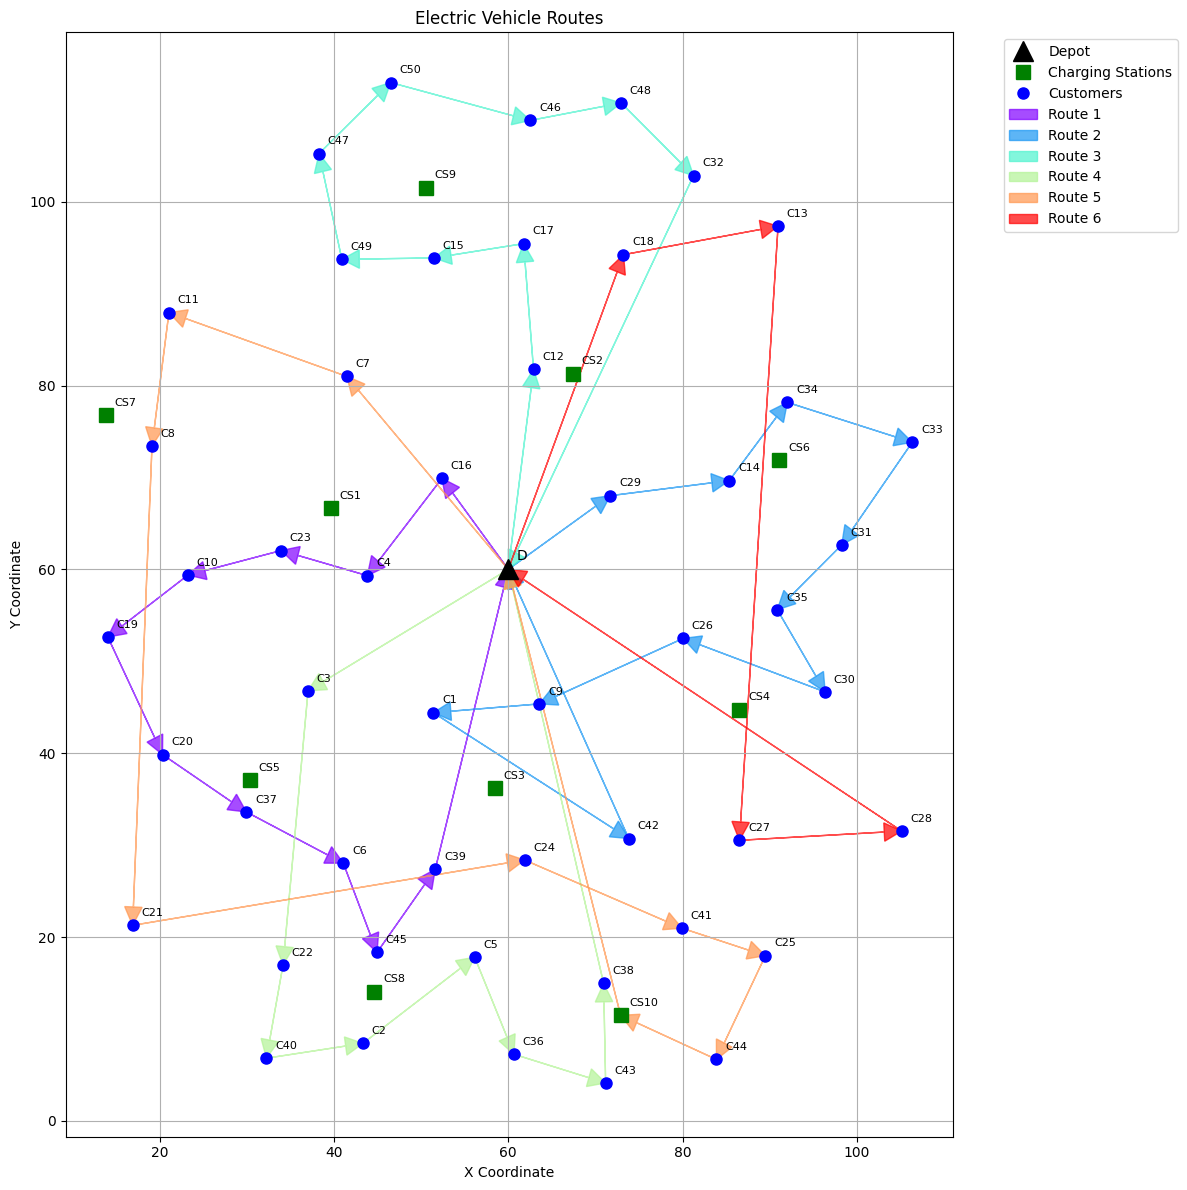

In [8]:
def read_toml_input(file_path):
    """Read EVRP instance data from TOML file"""
    try:
        data = toml.load(file_path)
        
        # Extract required fields
        instance = {
            'instance_id': os.path.basename(file_path).split('.')[0],
            'depot_location': data['depot_location'],
            'customer_locations': data['customer_locations'],
            'charging_stations': data['charging_stations'],
            'customer_items_weights': data['customer_items_weights'],
            'charging_rate': data['charging_rate'],
            'vehicle_speed': data.get('vehicle_speed', 25),  # default if not specified
            'ev_parameters': data.get('ev_parameters', None)
        }
        
        # Validate data
        validate_input_data(instance)
        return instance
        
    except Exception as e:
        raise Exception(f"Error reading TOML file: {str(e)}")

def validate_input_data(instance):
    """Validate the input data format and constraints"""
    # Check if all required fields exist
    required_fields = ['instance_id', 'depot_location', 'customer_locations', 
                      'charging_stations', 'customer_items_weights', 'charging_rate']
    
    for field in required_fields:
        if field not in instance:
            raise ValueError(f"Missing required field: {field}")
    
    # Validate dimensions
    if len(instance['depot_location']) != 2:
        raise ValueError("Depot location must be a 2D point")
    
    if not all(len(loc) == 2 for loc in instance['customer_locations']):
        raise ValueError("All customer locations must be 2D points")
        
    if not all(len(loc) == 2 for loc in instance['charging_stations']):
        raise ValueError("All charging station locations must be 2D points")
        
    # Check if number of weights matches number of customers
    if len(instance['customer_items_weights']) != len(instance['customer_locations']):
        raise ValueError("Number of weights must match number of customers")
        
    # Validate numeric values
    if instance['charging_rate'] <= 0:
        raise ValueError("Charging rate must be positive")
        
    if any(w <= 0 for w in instance['customer_items_weights']):
        raise ValueError("All customer weights must be positive")

def run_ev_routing(toml_file_path):
    """Main function to run EV routing problem"""
    print(f"Loading data from {toml_file_path}...")
    
    # Read and validate input
    instance_data = read_toml_input(toml_file_path)
    
    # Create problem instance
    instance = EVRPInstance(
        instance_id=instance_data['instance_id'],
        depot_location=instance_data['depot_location'],
        customer_locations=instance_data['customer_locations'],
        charging_stations=instance_data['charging_stations'],
        customer_items_weights=instance_data['customer_items_weights'],
        charging_rate=instance_data['charging_rate']
    )
    
    # Print problem details
    print("\nProblem Instance Details:")
    print(f"Instance ID: {instance_data['instance_id']}")
    print(f"Number of Customers: {len(instance_data['customer_locations'])}")
    print(f"Number of Charging Stations: {len(instance_data['charging_stations'])}")
    print(f"Total Delivery Weight: {sum(instance_data['customer_items_weights'])} kg")
    print(f"Charging Rate: {instance_data['charging_rate']} kWh/h")
    
    # Create and run solver
    print("\nInitializing Greedy EVRP Solver...")
    solver = GreedyEVRPSolver(instance)
    
    print("Solving problem...")
    solution = solver.solve()
    
    # Print solution
    print("\n=== Solution Details ===")
    print(f"Total routes (vehicles used): {len(solution.routes)}")
    
    vehicle_counts = {}
    total_distance = 0
    total_energy = 0
    total_customers = 0
    
    for i, (route, v_type, load) in enumerate(zip(
            solution.routes, solution.vehicle_types, solution.route_loads)):
        
        # Calculate metrics including battery levels
        distance, energy, time, battery_levels = solver.calculate_route_metrics(route, load, v_type)
        
        # Update vehicle counts
        vehicle_counts[v_type] = vehicle_counts.get(v_type, 0) + 1
        
        print(f"\nRoute {i+1}:")
        print(f"Vehicle Type: {v_type.upper()}")
        print(f"Load: {load:.2f} kg")
        
        # Convert route to readable format with battery levels
        print("Sequence with battery levels:")
        for stop_idx, (loc, battery) in enumerate(battery_levels):
            if loc == 0:
                location_str = "D"  # Depot
            elif loc > 0:
                location_str = f"C{loc}"  # Customer
            else:
                location_str = f"CS{-loc}"  # Charging Station
            
            # Add arrow for all but last stop
            arrow = " → " if stop_idx < len(battery_levels) - 1 else ""
            print(f"{location_str} ({battery:.1f}%){arrow}", end="")
        print()  # New line after sequence
        
        print(f"Distance: {distance:.2f} km")
        print(f"Energy: {energy:.2f} kWh")
        print(f"Time: {time:.2f} hours")
        
        num_customers = sum(1 for loc in route if loc > 0)
        num_charges = sum(1 for loc in route if loc < 0)
        print(f"Customers served: {num_customers}")
        print(f"Charging stops: {num_charges}")
        
        total_distance += distance
        total_energy += energy
        total_customers += num_customers
    
    # Print summary statistics
    print("\n=== Overall Statistics ===")
    print("Vehicle Distribution:")
    for v_type, count in vehicle_counts.items():
        print(f"{v_type.upper()}: {count} vehicles")
    
    if total_distance > 0 and total_customers > 0:
        print(f"\nTotal distance: {total_distance:.2f} km")
        print(f"Total energy consumption: {total_energy:.2f} kWh")
        print(f"Average energy per km: {total_energy/total_distance:.3f} kWh/km")
        print(f"Total customers served: {total_customers}")
        print(f"Average distance per customer: {total_distance/total_customers:.2f} km")
    else:
        print("\nNo feasible routes were found!")
        print("Possible reasons:")
        print("- Vehicle capacity constraints")
        print("- Battery range limitations")
        print("- Distance/energy constraints")
        print("Consider adjusting vehicle parameters or problem constraints")
    
    print(f"Computation time: {solution.computation_time:.2f} seconds")

    
    # Plot solution
    print("\nGenerating visualization...")
    plt.figure(figsize=(12, 12))
    
    # Plot depot
    plt.plot(instance.depot_location[0], instance.depot_location[1], 
            'k^', markersize=15, label='Depot')
    plt.text(instance.depot_location[0] + 1, instance.depot_location[1] + 1, 
            'D', fontsize=10)
    
    # Plot charging stations
    charging_stations = np.array(instance.charging_stations)
    plt.plot(charging_stations[:, 0], charging_stations[:, 1], 
            'gs', markersize=10, label='Charging Stations')
    for i, (x, y) in enumerate(charging_stations):
        plt.text(x + 1, y + 1, f'CS{i+1}', fontsize=8)
    
    # Plot customers with numbers
    customers = np.array(instance.customer_locations)
    plt.plot(customers[:, 0], customers[:, 1], 
            'bo', markersize=8, label='Customers')
    for i, (x, y) in enumerate(customers):
        plt.text(x + 1, y + 1, f'C{i+1}', fontsize=8)
    
    # Plot routes with arrows to show direction
    colors = plt.cm.rainbow(np.linspace(0, 1, len(solution.routes)))
    all_locations = [instance.depot_location] + instance.customer_locations
    
    for route_idx, (route, color) in enumerate(zip(solution.routes, colors)):
        for i in range(len(route) - 1):
            # Get coordinates for current segment
            if route[i] >= 0:
                start = all_locations[route[i]]
            else:
                start = instance.charging_stations[-route[i]-1]
                
            if route[i+1] >= 0:
                end = all_locations[route[i+1]]
            else:
                end = instance.charging_stations[-route[i+1]-1]
            
            # Draw arrow
            plt.arrow(start[0], start[1], 
                     end[0] - start[0], end[1] - start[1],
                     head_width=2, head_length=2, fc=color, ec=color,
                     length_includes_head=True, alpha=0.7,
                     label=f'Route {route_idx+1}' if i == 0 else "")
    
    plt.title('Electric Vehicle Routes')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    
    # Move legend outside plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    return solver, solution
        

if __name__ == "__main__":
    # Example usage
    toml_path = "/Users/chanakyavasantha/Comsets/test_cases/customers_50/c50_6.toml"
    solver, solution = run_ev_routing(toml_path)